# Analysis: track ring eigenvectors

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import proplot as pplt
import psdist as ps
import psdist.visualization as psv
import yaml
from ipywidgets import interact
from ipywidgets import widgets
from omegaconf import OmegaConf
from omegaconf import DictConfig
from pprint import pprint

In [2]:
pplt.rc["cmap.discrete"] = False
pplt.rc["cmap.sequential"] = "viridis"
pplt.rc["cycle"] = "538"
pplt.rc["grid"] = False
pplt.rc["figure.facecolor"] = "white"

## Setup

In [3]:
timestamp = None
script_name = "track_eig"

if timestamp is None:
    input_dirs = os.listdir(f"./outputs/{script_name}")
    input_dirs = sorted(input_dirs)
    input_dir = input_dirs[-1]
    input_dir = os.path.join(f"./outputs/{script_name}", input_dir)
else:
    input_dir = f"./outputs/{script_name}/{timestamp}/"

print("intput_dir = ", input_dir)

intput_dir =  ./outputs/track_eig/240517143559


In [4]:
cfg_path = os.path.join(input_dir, "config/config.yaml")
cfg = yaml.safe_load(open(cfg_path, "r"))
cfg = DictConfig(cfg)

print("config:")
print(OmegaConf.to_yaml(cfg))

config:
timestamp: ${now:%y%m%d%H%M%S}
bunch:
  mass: 0.93827231
  energy: 0.8
lattice:
  path: ./lattice/sns_ring_nux6.175_nuy6.175_sol.lattice
  seq: rnginjsol
  apertures: false
  foil: false
  fringe: 0
  impedance:
    xy: false
    z: false
  spacecharge:
    xy: false
    z: false
  rf: false
  solenoid: true
foil:
  thickness: 390.0
  scatter: full
  parent_index: 0
impedance:
  xy:
    n_bins: 64
    use_x: false
    use_y: true
    alpha_x: 0.0
    alpha_y: -0.004
    beta_x: 10.191
    beta_y: 10.447
    tune_x: 6.21991
    tune_y: 6.20936
  z:
    n_macros_min: 1000
    n_bins: 128
inj:
  intensity: 225800000000.0
  x:
    order: 9
    alpha: 0.064
    beta: 10.056
    eps: 2.21e-07
    pos: 0.0486
    mom: 0.0
  'y':
    order: 9
    alpha: 0.063
    beta: 10.815
    eps: 2.21e-07
    pos: 0.046
    mom: 0.0
  z:
    fill_fraction: 139.68
    tail_fraction: 0.0
    energy:
      sigma: 0.0005
      trunc: 1.0
      min: -0.0025
      max: 0.0025
      centroid:
        mea

## Load transfer matrix

In [5]:
M = np.loadtxt(os.path.join(input_dir, "transfer_matrix.dat"))

from orbitsim import coupling
eigvals, eigvecs = np.linalg.eig(M)
eigtunes = coupling.eigentunes_from_eigenvalues(eigvals)
eigvecs = coupling.normalize_eigenvectors(eigvecs)

## Analysis

In [6]:
coords = np.load(os.path.join(input_dir, "coords.npy"))
coords = coords[:, :, :4]
coords *= 1000.0
coords.shape

(1001, 2, 4)

In [7]:
v1 = coords[:, 0, :]
v2 = coords[:, 1, :]

### Corner

In [8]:
dims = ["x", "xp", "y", "yp", "z", "dE"]
units = ["mm", "mrad", "mm", "mrad", "m", "MeV"]
labels = [f"{dim} [{unit}]" for dim, unit in zip(dims, units)]
limits = [ps.points.limits(v, zero_center=True, share=[(0, 2), (1, 3)], pad=0.25) for v in [v1, v2]]
limits = psv.combine_limits(limits)

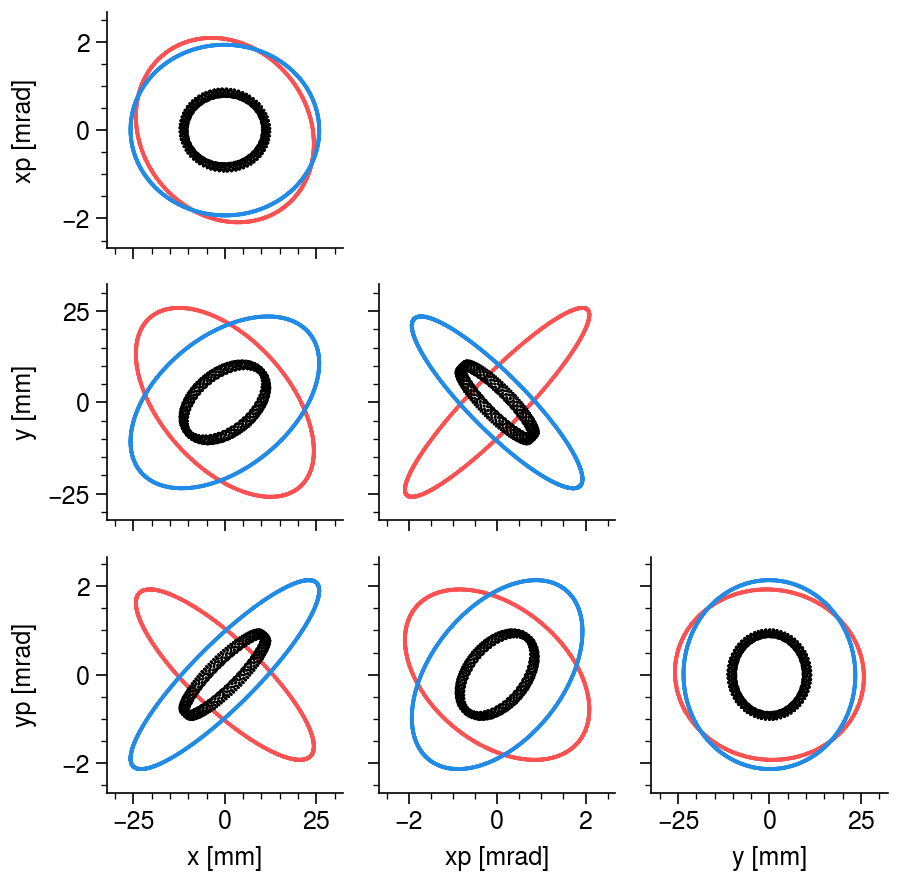

In [54]:
grid = psv.CornerGrid(d=4, diag=False)
grid.plot_points(v1, kind="scatter", c="red6")
grid.plot_points(v2, kind="scatter", c="blue6")
grid.set_labels(labels)
grid.set_limits(limits)

# Plot an injected particle.
x = np.zeros((1000, 4))
x[0] = [10.0, +0.25, 0.0, 1.0]
for i in range(1, x.shape[0]):
    x[i] = np.matmul(M, x[i - 1])
grid.plot_points(x, kind="scatter", c="black", s=1)

plt.show()